<a href="https://colab.research.google.com/github/dausech/misc/blob/master/IQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
 import datetime
from datetime import date
from datetime import timedelta
import pandas as pd
from IPython.display import display, HTML

In [0]:
feriados = {}
feriados[datetime.datetime(2020, 2, 24).strftime("%d/%m/%Y")] = True
feriados[datetime.datetime(2020, 2, 25).strftime("%d/%m/%Y")] = True

### Escolha a empresa 0(PETR4) - 1(BBAS3) - 2(ITSA4)

In [0]:

empresas=['PETROLEO%20BRASILEIRO%20S.A.%20PETROBRAS','BCO%20BRASIL%20S.A.','ITAUSA%20INVESTIMENTOS%20ITAU%20S.A.']
#PETR4 - 0
#BBAS3 - 1
#ITSA4 - 2

empresa =  empresas[0] 


### Funções

In [0]:
def isFeriado(data):
  return feriados.get(data.strftime("%d/%m/%Y"))

##### Calcula a data de vencimento do próximo strike
def getDataVencimento(data):
    dia1Mes = data - timedelta(data.day-1)
    weekDay1 = dia1Mes.weekday()
    
    contador = 0
    diaVencimento = 0
    
    while(contador < 3):
        diaVencimento += 1        
        if(weekDay1 % 7) == 0:
            contador += 1
            
        weekDay1 +=1
        
    return data.replace(day=diaVencimento)

##### Pega o dia de negociação anterior
def getDiaDeNegociacaoAnterior(dataReferencia):
  diaAnterior = dataReferencia - datetime.timedelta(days=1)
  feriado = isFeriado(diaAnterior)
  sabado = diaAnterior.weekday() == 5
  domingo = diaAnterior.weekday() == 6

  if(feriado or sabado or domingo):
    return getDiaDeNegociacaoAnterior(diaAnterior)
  else :
    return diaAnterior


##### Monta a URL de CONSULTA de opções
def getUrlConsulta(dataConsulta, dataVencimento, empresa):
    dataConsulta = dataConsulta.strftime("%d/%m/%Y")
    dataVencimento = dataVencimento.strftime("%d/%m/%Y")
    
    url = "http://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/consultas/mercado-a-vista/opcoes/posicoes-em-aberto/posicoes-em-aberto-8AE490CA64BA055F0164CCCAE1F1460A.htm?" 
    url = "http://www.bmfbovespa.com.br/pt_br/servicos/market-data/consultas/mercado-a-vista/opcoes/posicoes-em-aberto/posicoes-em-aberto-2.htm?"
    url += 'empresaEmissora=' + empresa + '&f=0'
    url += "&data=" + dataConsulta
    url += "&dataVencimento=" + dataVencimento

    return url

#### 
def extracaoOpcoes(calls):
  calls.columns = ['serie','exercicio','coberto','trava','descoberto','total','titular','lancador']
  calls = calls.sort_values(by=['exercicio'])
  calls.drop(calls.tail(1).index,inplace=True)
  
  hashMap = {}
  for index, row in calls.iterrows():

    titular = row[6]
    lancador = row[7]
    
    iq = round(titular/lancador,2) 
    
    descobertos = row[4]

    total = row[5]
                
    strike = row[1]
                    
    codigo = row[0].strip()
    hashMap[codigo] = [codigo, strike, iq, descobertos, total, titular, lancador]
  
  return hashMap

def montaTabela(callsPenultimoDia, callsUltimoDia):
  dados =[]
  for opcao in callsPenultimoDia:
    ultimo = callsUltimoDia.get(opcao)
    penultimo = callsPenultimoDia.get(opcao)
    if(not ultimo) or (not penultimo):
      continue
    
    diferencaIQ = ultimo[2] - penultimo[2]
    
    IQ = "%1.2f (%1.2f)" % (ultimo[2], diferencaIQ)
    
    descobertas = "%d,2 MM " % (ultimo[3]/1000000)
    descobertas = descobertas.rjust(4, " ")

    difDescobertas = (ultimo[3] - penultimo[3])/1000000
    difDescobertas = "%1.2f" % difDescobertas
    difDescobertas = difDescobertas.rjust(5, "+")
    
    descobertas = descobertas + " (" + difDescobertas + ")"

    total = "%d,2 MM " % (ultimo[4]/1000000)
    total = total.rjust(4, " ")

    difTotal = (ultimo[4] - penultimo[4])/1000000
    difTotal = "%1.2f" % difTotal
    difTotal = difTotal.rjust(5, "+")

    total = total + " (" + difTotal + ")"

    #print("%8s - R$ %s - IQ:%1.2f (%s) - V Descobertas: %s (%s) MM - Compradores: %d" %(ticker, strike, opcao[2], diferenca, descobertas, diferencaDescobertas, opcao[4]))
    ##arquivo.write("%s - R$ %s - IQ:%1.2f (%s) - V Descobertas: %s (%s) MM - Compradores: %d\n" %(ticker, strike, opcao[2], diferenca, descobertas, diferencaDescobertas, opcao[4]))

    dados.append([ultimo[0], ultimo[1], IQ, descobertas, total , ultimo[5], ultimo[6]])

  return dados

### Pega a data do vencimento e os dois últimos dias de negociação

In [0]:
#Data de consulta de hoje e url
hoje =  date.today()
print ("Hoje é", hoje.strftime("%d/%m/%Y"))

#atrasando um dia por causa da B3
#deltaDias = datetime.timedelta(days=1)
#hoje = hoje - deltaDias


dataVencimento = getDataVencimento(hoje)
if (dataVencimento <= hoje):
    diaMesQueVem = hoje + datetime.timedelta(days=30)
    dataVencimento = getDataVencimento(diaMesQueVem)

Hoje é 26/03/2020


In [0]:
vencimento = dataVencimento.strftime("%d/%m/%Y")
print("Vencimento: {}".format(vencimento))

Vencimento: 20/04/2020


In [0]:
ultimoDiaUtil = getDiaDeNegociacaoAnterior(hoje)
dataConsulta = ultimoDiaUtil.strftime("%d/%m/%Y") 
print("Data do último dia de negociação: {}".format(dataConsulta))

urlUltimoDia = getUrlConsulta(ultimoDiaUtil, dataVencimento, empresa)
print (urlUltimoDia)
print ()

#Data de consulta de ontem url
deltaDias = datetime.timedelta(days=1)
ontem = hoje - deltaDias

penultimoDiaUtil = getDiaDeNegociacaoAnterior(ultimoDiaUtil) 

penultimaDataConsulta = penultimoDiaUtil.strftime("%d/%m/%Y") 
print("Data do peníltimo dia negociação: {}".format(penultimaDataConsulta))

urlPenultimoDiaUtil = getUrlConsulta(penultimoDiaUtil, dataVencimento, empresa)
print (urlPenultimoDiaUtil)
print ()


Data do último dia de negociação: 25/03/2020
http://www.bmfbovespa.com.br/pt_br/servicos/market-data/consultas/mercado-a-vista/opcoes/posicoes-em-aberto/posicoes-em-aberto-2.htm?empresaEmissora=PETROLEO%20BRASILEIRO%20S.A.%20PETROBRAS&f=0&data=25/03/2020&dataVencimento=20/04/2020

Data do peníltimo dia negociação: 24/03/2020
http://www.bmfbovespa.com.br/pt_br/servicos/market-data/consultas/mercado-a-vista/opcoes/posicoes-em-aberto/posicoes-em-aberto-2.htm?empresaEmissora=PETROLEO%20BRASILEIRO%20S.A.%20PETROBRAS&f=0&data=24/03/2020&dataVencimento=20/04/2020



### Busca as tabelas no site da B3 e Monta os Dataframes dos dois últimos dias.

In [0]:
tabelasUltimoDia = pd.read_html(urlUltimoDia, encoding="UTF-8", thousands='.', decimal=',')
tabelasPenultimoDia = pd.read_html(urlPenultimoDiaUtil, encoding="UTF-8", thousands='.', decimal=',')

# PETRO tem PN e ON
indiceCalls = 0
indicePuts = 1
print(len(tabelasUltimoDia))
if(len(tabelasUltimoDia)> 2):
  indiceCalls = 1
  indicePuts = 3

callsUltimoDia = extracaoOpcoes(tabelasUltimoDia[indiceCalls])
callsPenultimoDia = extracaoOpcoes(tabelasPenultimoDia[indiceCalls])

putsUltimoDia =  extracaoOpcoes(tabelasUltimoDia[indicePuts])
putsPenultimoDia = extracaoOpcoes(tabelasPenultimoDia[indicePuts])

4


# CALLS DO VENCIMENTO ATUAL

In [0]:
dados = montaTabela(callsPenultimoDia, callsUltimoDia)
dfIQ = pd.DataFrame(dados, columns=['Código', 'Strike', 'IQ', 'Descobertas', 'Total', 'Titulares', 'Lançadores'])
display(HTML(dfIQ[10:45].to_html())) ### Escolhe a quantidade de opções para mostrar

,Código,Strike,IQ,Descobertas,Total,Titulares,Lançadores
10,PETRD127,12.70,0.72 (-0.06),"0,2 MM (+0.01)","1,2 MM (+0.12)",208,287
11,PETRD129,12.95,0.74 (-0.14),"1,2 MM (+0.02)","3,2 MM (-0.15)",131,177
12,PETRD132,13.20,0.59 (-0.12),"0,2 MM (+0.07)","1,2 MM (+0.02)",108,184
13,PETRD134,13.45,0.40 (0.03),"0,2 MM (-0.10)","0,2 MM (+0.11)",19,47
14,PETRD137,13.70,1.34 (-0.13),"1,2 MM (+0.23)","3,2 MM (+0.04)",724,540
15,PETRD139,13.95,0.75 (0.03),"0,2 MM (+0.16)","1,2 MM (+0.11)",143,191
16,PETRD142,14.20,0.68 (-0.01),"0,2 MM (+0.05)","1,2 MM (+0.15)",115,169
17,PETRD144,14.45,0.42 (-0.01),"0,2 MM (+0.01)","0,2 MM (+0.01)",20,48
18,PETRD147,14.70,0.83 (-0.14),"2,2 MM (+0.12)","6,2 MM (-0.34)",443,534
19,PETRD149,14.95,0.31 (-0.06),"2,2 MM (+0.20)","3,2 MM (+0.30)",143,455


# PUTS DO VENCIMENTO ATUAL

In [0]:
dados = montaTabela(putsPenultimoDia, putsUltimoDia)
dfIQ = pd.DataFrame(dados, columns=['Código', 'Strike', 'IQ', 'Descobertas', 'Total', 'Titulares', 'Lançadores'])
display(HTML(dfIQ[0:45].to_html()))


,Código,Strike,IQ,Descobertas,Total,Titulares,Lançadores
0,PETRP10,10.20,1.45 (-0.19),"1,2 MM (+0.07)","3,2 MM (+0.42)",428,295
1,PETRP104,10.45,1.89 (-0.19),"0,2 MM (+0.03)","0,2 MM (+0.11)",51,27
2,PETRP107,10.70,1.55 (-0.05),"3,2 MM (+0.12)","6,2 MM (+0.34)",653,422
3,PETRP109,10.95,1.45 (0.01),"0,2 MM (+0.01)","0,2 MM (+0.05)",71,49
4,PETRP11,11.20,1.96 (0.04),"0,2 MM (+0.03)","0,2 MM (+0.20)",223,114
5,PETRP114,11.45,1.29 (-0.42),"0,2 MM (+0.02)","0,2 MM (+0.07)",44,34
6,PETRP117,11.70,1.95 (0.01),"0,2 MM (-0.04)","6,2 MM (+0.43)",302,155
7,PETRP119,11.95,1.24 (0.06),"0,2 MM (+0.01)","0,2 MM (+0.17)",46,37
8,PETRP12,12.20,2.11 (0.24),"1,2 MM (+1.03)","2,2 MM (+1.08)",207,98
9,PETRP124,12.45,1.48 (0.23),"0,2 MM (-0.00)","0,2 MM (+0.04)",34,23


### Buscando o próximo vencimento

In [0]:
proximoVencimento = getDataVencimento(dataVencimento + timedelta(dataVencimento.day+1))
urlUltimoDiaProximoVencimento = urlUltimoDia[0:len(urlUltimoDia)-10]
urlPenultimoDiaUtilProximoVencimento = urlPenultimoDiaUtil[0:len(urlUltimoDia)-10]

urlUltimoDiaProximoVencimento += proximoVencimento.strftime("%d/%m/%Y")
urlPenultimoDiaUtilProximoVencimento += proximoVencimento.strftime("%d/%m/%Y")

In [0]:
print("URL Último dia do próximo vencimento", urlUltimoDiaProximoVencimento)
print("URL Penúltimo dia do próximo vencimento", urlPenultimoDiaUtilProximoVencimento)

URL Último dia do próximo vencimento http://www.bmfbovespa.com.br/pt_br/servicos/market-data/consultas/mercado-a-vista/opcoes/posicoes-em-aberto/posicoes-em-aberto-2.htm?empresaEmissora=PETROLEO%20BRASILEIRO%20S.A.%20PETROBRAS&f=0&data=25/03/2020&dataVencimento=18/05/2020
URL Penúltimo dia do próximo vencimento http://www.bmfbovespa.com.br/pt_br/servicos/market-data/consultas/mercado-a-vista/opcoes/posicoes-em-aberto/posicoes-em-aberto-2.htm?empresaEmissora=PETROLEO%20BRASILEIRO%20S.A.%20PETROBRAS&f=0&data=24/03/2020&dataVencimento=18/05/2020


In [0]:
tabelasUltimoDiaProximoVencimento = pd.read_html(urlUltimoDiaProximoVencimento, encoding="UTF-8", thousands='.', decimal=',')
tabelasPenultimoDiaProximoVencimento = pd.read_html(urlPenultimoDiaUtilProximoVencimento, encoding="UTF-8", thousands='.', decimal=',')

callsUltimoDiaProximoVencimento = extracaoOpcoes(tabelasUltimoDiaProximoVencimento[1])
callsPenultimoDiaProximoVencimento = extracaoOpcoes(tabelasPenultimoDiaProximoVencimento[1])

putsUltimoDiaProximoVencimento =  extracaoOpcoes(tabelasUltimoDiaProximoVencimento[3])
putsPenultimoDiaProximoVencimento = extracaoOpcoes(tabelasPenultimoDiaProximoVencimento[3])

# CALLS DO PRÓXIMO VENCIMENTO

In [0]:
dados = montaTabela(callsPenultimoDiaProximoVencimento, callsUltimoDiaProximoVencimento)
dfIQ = pd.DataFrame(dados, columns=['Código', 'Strike', 'IQ', 'Descobertas','Total', 'Titulares', 'Lançadores'])
display(HTML(dfIQ[0:55].to_html()))

,Código,Strike,IQ,Descobertas,Total,Titulares,Lançadores
0,PETRE10,10.22,2.00 (0.20),"0,2 MM (+0.00)","0,2 MM (+0.02)",10,5
1,PETRE40,10.72,1.00 (0.00),"0,2 MM (-0.00)","0,2 MM (+0.00)",6,6
2,PETRE11,11.22,1.25 (0.00),"0,2 MM (+0.00)","0,2 MM (+0.00)",10,8
3,PETRE41,11.72,2.60 (-0.78),"0,2 MM (-0.01)","0,2 MM (+0.02)",26,10
4,PETRE12,12.22,2.26 (-0.45),"0,2 MM (-0.01)","0,2 MM (+0.01)",43,19
5,PETRE42,12.72,2.29 (0.29),"0,2 MM (+0.00)","0,2 MM (+0.03)",16,7
6,PETRE13,13.22,19.47 (-1.53),"0,2 MM (-0.10)","1,2 MM (+0.04)",584,30
7,PETRE43,13.72,3.12 (-0.55),"0,2 MM (-0.09)","0,2 MM (+0.01)",53,17
8,PETRE150,14.22,3.23 (-0.14),"1,2 MM (+0.37)","1,2 MM (+0.38)",142,44
9,PETRE147,14.72,1.10 (-0.14),"0,2 MM (+0.06)","0,2 MM (+0.11)",44,40


# PUTS DO PRÓXIMO VENCIMENTO

In [0]:
dados = montaTabela(putsPenultimoDiaProximoVencimento, putsUltimoDiaProximoVencimento)
dfIQ = pd.DataFrame(dados, columns=['Código', 'Strike', 'IQ', 'Descobertas','Total', 'Titulares', 'Lançadores'])
display(HTML(dfIQ[24:50].to_html()))


,Código,Strike,IQ,Descobertas,Total,Titulares,Lançadores
24,PETRQ219,21.22,0.33 (-0.05),"0,2 MM (+0.01)","0,2 MM (+0.01)",5,15
25,PETRQ227,22.72,0.21 (-0.07),"0,2 MM (+0.01)","0,2 MM (+0.01)",4,19
26,PETRQ24,23.22,0.34 (0.01),"0,2 MM (+0.04)","0,2 MM (+0.04)",10,29
27,PETRQ75,24.72,0.41 (-0.05),"0,2 MM (-0.01)","0,2 MM (+0.00)",11,27
28,PETRQ249,24.97,0.30 (-0.05),"0,2 MM (+0.00)","0,2 MM (+0.00)",7,23
29,PETRQ252,25.22,0.31 (-0.02),"0,2 MM (+0.00)","0,2 MM (+0.00)",5,16
30,PETRQ261,25.47,0.43 (0.00),"0,2 MM (+0.00)","0,2 MM (+0.00)",6,14
31,PETRQ264,25.72,0.78 (0.00),"0,2 MM (+0.00)","0,2 MM (+0.00)",7,9
32,PETRQ259,25.97,0.50 (0.00),"0,2 MM (-0.01)","0,2 MM (-0.00)",7,14
33,PETRQ262,26.22,0.24 (-0.03),"0,2 MM (+0.00)","0,2 MM (+0.00)",7,29


### Montando Histórico de vários dias

In [0]:
diaConsulta = hoje
datas = []
dias = []
for i in range(1,20):
  diaConsulta = getDiaDeNegociacaoAnterior(diaConsulta)
  datas.append(diaConsulta)

  urlConsulta = getUrlConsulta(diaConsulta, dataVencimento, empresa)
  tabelas = pd.read_html(urlConsulta, encoding="UTF-8", thousands='.', decimal=',')
  
  dias.append(extracaoOpcoes(tabelas[1]))
  
dias.reverse()
datas.reverse()

In [0]:
diaMaisAtual = dias[-1]
tickers = []
vendasDescobertas = []
for ticker in diaMaisAtual:
  tickers.append(ticker + " (" + diaMaisAtual[ticker][1] + ")")
  
  vendasNoDia = []
  for dia in dias:
    dadosDoTickerNoDia = dia.get(ticker)
    if dadosDoTickerNoDia:
      vendasNoDia.append(dadosDoTickerNoDia[3])
    else:
      vendasNoDia.append(0)
  vendasDescobertas.append(vendasNoDia)

tabela = []
for (ticker, vendas) in zip(tickers, vendasDescobertas):
  linha = [ticker]
  linha.extend(vendas)
  tabela.append(linha)

colunas = ["Código"]
colunas.extend(datas)
progressaoVendas = pd.DataFrame(tabela,columns=colunas)
display(HTML(progressaoVendas[15:54].to_html()))



,Código,2020-02-28,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-23,2020-03-24,2020-03-25
15,PETRD139 (13.95),0,0,0,0,0,0,0,400,132400,148600,82000,86300,121600,211700,251500,289200,396200,413100,570600
16,PETRD142 (14.20),0,0,0,0,0,0,0,0,0,0,0,0,0,67100,53700,221600,215500,321300,371900
17,PETRD144 (14.45),0,0,0,0,0,0,0,0,0,0,0,0,0,100,15500,27400,28300,41100,52200
18,PETRD147 (14.70),0,0,0,0,0,0,1000,4700,4100,41500,136600,273000,639600,1197900,2031200,2116400,2654200,2532500,2655300
19,PETRD149 (14.95),0,0,0,0,0,0,201300,227300,250400,287000,357300,470200,650800,1521700,1275600,1481900,1478900,1890300,2094900
20,PETRD152 (15.20),0,0,0,0,0,0,0,0,0,0,0,0,0,20300,116300,89200,160000,211400,300500
21,PETRD154 (15.45),0,0,0,0,0,0,0,0,0,0,0,0,0,0,19200,34600,76400,129500,140900
22,PETRD157 (15.70),0,0,0,0,0,0,91100,44800,41500,81800,262100,696900,937900,950400,733800,1493500,840400,1122500,1420900
23,PETRD159 (15.95),0,0,0,0,0,0,187100,222400,235000,829900,883000,110100,485100,572700,612900,809400,884800,1507600,1229500
24,PETRD162 (16.20),0,0,0,0,0,0,0,0,0,0,0,0,0,4000,70300,286600,344200,554300,649600


### Geração do Gráfico de PETR4 - 20 pregões

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Empty DataFrame
Columns: [Código, 2020-02-28, 2020-03-02, 2020-03-03, 2020-03-04, 2020-03-05, 2020-03-06, 2020-03-09, 2020-03-10, 2020-03-11, 2020-03-12, 2020-03-13, 2020-03-16, 2020-03-17, 2020-03-18, 2020-03-19, 2020-03-20, 2020-03-23, 2020-03-24, 2020-03-25]
Index: []


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


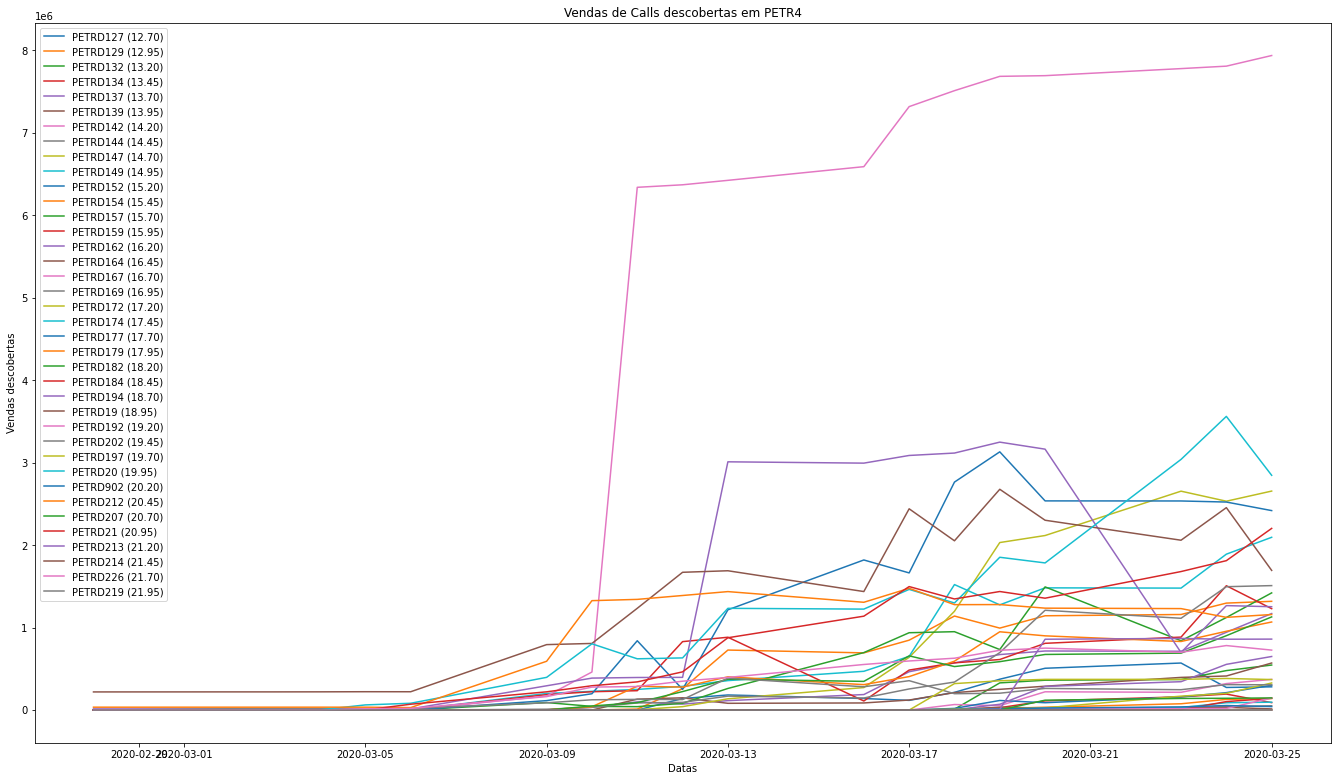

In [0]:
fig = plt.figure(figsize=(18,10))
axes = fig.add_axes([1,1,1,1])
axes.set_xlabel('Datas')
axes.set_ylabel('Vendas descobertas')
axes.set_title('Vendas de Calls descobertas em PETR4')

print(progressaoVendas[0:0][1:])

for linha in tabela[10:48]:
  axes.plot(datas,linha[1:],label=linha[0])
axes.legend()